<a href="https://colab.research.google.com/github/thayeylolu/cyberbullying/blob/main/notebooks/the_multiclass_text_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS 

### Installation
- install torchtext and scikit plot


In [1]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 10.6 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Libaries

In [3]:
import scikitplot as skplt
import random
import time
import pandas as pd
import numpy as np
import re
import os 
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.express as px
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from torch.optim.optimizer import Optimizer
from multiprocessing import  Pool



### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Url to data

In [5]:
url = "/content/drive/MyDrive/NLP/train_data.csv"


### Load and Split Data
- define random seeds
- read csv file path using a pandas
- drop empty rows 
- select `cyberbullying_type`, `clean_txt_emoji` only
- split data into train, test and valid 


In [6]:
np.random.seed(3040)
random.seed(3040)
torch.manual_seed(3040) 

df = pd.read_csv(url)
df = df.dropna()
df = df[['cyberbullying_type', 'clean_txt_emoji']]

train, test_valid = train_test_split(df,train_size= 0.70, random_state= 3040)
test, valid = train_test_split(test_valid,train_size= .50, random_state= 3040)


### Prepare Data For DataLoading and Tokenization



In [7]:
train_X, train_y = train['clean_txt_emoji'].to_list(), train['cyberbullying_type'].to_list()
test_X, test_y = test['clean_txt_emoji'].to_list(), test['cyberbullying_type'].to_list()
valid_X, valid_y = valid['clean_txt_emoji'].to_list(), valid['cyberbullying_type'].to_list()

train_dat =list(zip(train_y,train_X))
valid_dat =list(zip(valid_y,valid_X))
test_dat=list(zip(test_y,test_X))

In [8]:
import math
embed_size = 300 #() how big is each word vector
max_features = math.trunc(len(list( train['clean_txt_emoji'].str.split(' ', expand=True).stack().unique())))/2 # the unique words divided by 2 because some words could occur once
maxlen = 750 # max number of words 
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of Splits
SEED = 3040
debug = 0

In [9]:
max_features = math.trunc(max_features)

## Tokenization

- define a tokenizer
- fit the train data to it
- Create a sequence and pad the sequence for the trian, test and validate dataset

In [10]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))

train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)
valid_X = tokenizer.texts_to_sequences(valid_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
valid_X = pad_sequences(valid_X, maxlen=maxlen)

### Encode Label(CyberBullying Type) to numbers

- define a label encoder for the `cyberbullying_type`.
- fit and transform it on the train data
- apply the transform to the test and valid data

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)
valid_y = le.transform(valid_y)

### Load Embeddings

- download glove embedding text from ttp://nlp.stanford.edu/data/glove.840B.300d.zip
- save it in google drive path `/content/drive/MyDrive/NLP/`


In [12]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove*.zip
!ls
!pwd

import zipfile
with zipfile.ZipFile('glove.840B.300d.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/NLP/')

### Function to Embed Data
- code adopted from  https://www.kaggle.com/gmhost/gru-capsule

In [13]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index, embed_size):
    EMBEDDING_FILE = '/content/drive/MyDrive/NLP/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:embed_size]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

### Embed Vectors
- missing entries in the embedding are set using np.random.normal so we have to seed here too

In [14]:


if debug:
    embedding_matrix = np.random.randn(max_features, embed_size)
else:
    embedding_matrix = load_glove(tokenizer.word_index, embed_size)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Pytorch Model - TextCNN

Initializing the`Text CNN` 
- Create a list of kernel with different window sizes to be used during convultion
- Initialize Embedding Layer's weight by generating parameters from `embedding_matrix` created earlier
- `self.embedding.weight.requires_grad` is set to False because we dont want to train the embeddings weights during model training

- Input channel of 1,  non-square kernels and an output channel of `num_filters`
- We generated several convolution layers each having different kernel(filter) and stored  layers in a Module list
-  We set a dropout of 0.1 
- We finally created a fully connected network by passing the parameters to the last layer which is a linear layer< output layer>




In [15]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Train TextCNN Model
- set the random seeds
- define or initialize the `CNN_Text()` model class
- define loss function ` nn.CrossEntropyLoss()`
- define adam optimizer and learning rate
- send the model to the current device `cuda`
- load train and valid in CUDA Memory
- create Torch datasets for train and validate dataset
- initalize loss list for train and loss
- train model 

In [16]:

np.random.seed(3040)
random.seed(3040)
torch.manual_seed(3040) 

model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()

x_cv = torch.tensor(valid_X, dtype=torch.long).cuda()
y_cv = torch.tensor(valid_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=False)

# initalize loss list
train_loss = []
valid_loss = []

# training for all epochs
for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.0  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==valid_y)/len(valid_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/5 	 loss=404.3361 	 val_loss=235.3965  	 val_acc=0.8189  	 time=14.90s
Epoch 2/5 	 loss=232.3237 	 val_loss=203.0728  	 val_acc=0.8406  	 time=14.94s
Epoch 3/5 	 loss=203.2272 	 val_loss=191.3691  	 val_acc=0.8495  	 time=15.18s
Epoch 4/5 	 loss=187.4830 	 val_loss=185.3109  	 val_acc=0.8530  	 time=15.29s
Epoch 5/5 	 loss=175.4542 	 val_loss=181.3471  	 val_acc=0.8554  	 time=15.57s


### Save model

In [18]:
torch.save(model,'textcnn_model')

### Plot Train/Validation Loss curve

In [19]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

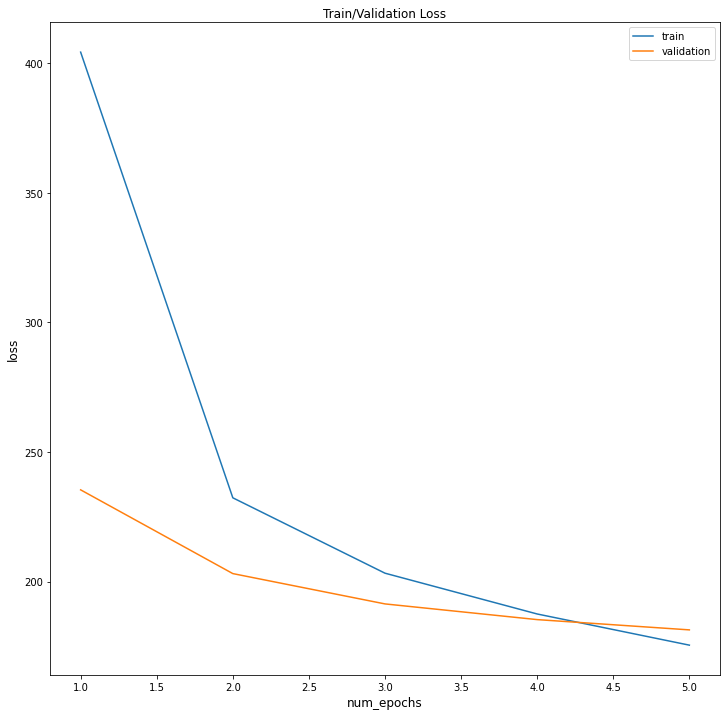

In [20]:
plot_graph(n_epochs)

### plot confusion matrix

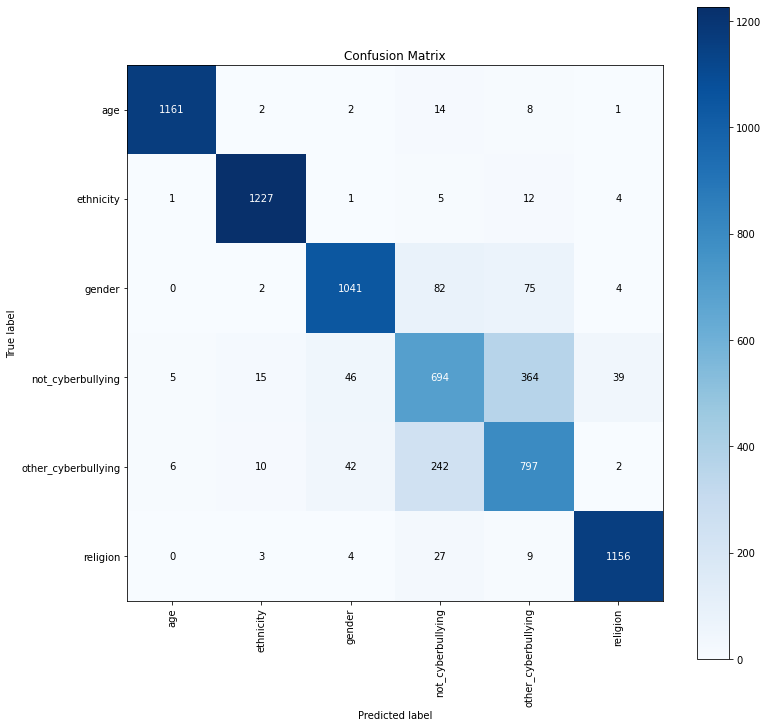

In [21]:

y_true = [le.classes_[x] for x in valid_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Pytorch Model - BiLSTM

## Pytorch Model - BiLSTM

Initializing the`BiLSTM` 

- set the hidden size to 64 and a drop out to 0.1
- Initialize Embedding Layer's weight by generating parameters from `embedding_matrix` created earlier
- `self.embedding.weight.requires_grad` is set to False because we dont want to train the embeddings.
- Defing the LSTM model and set the  bidirectional=True and batch_first=True. To use a bidirecitonal lstm and to process that data in batches respectively.


In the forward pass, we set the hidden state as the embedding, we make the second hidden state the lstm model. We gnenrate the average and max pool for the second hidden state. We connect it to the a RELU, whuch is then connected to a drop, the findally, the output layer

In [22]:
np.random.seed(3040)
random.seed(3040)
torch.manual_seed(3040) 

class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [23]:

np.random.seed(3040)
random.seed(3040)
torch.manual_seed(3040) 

model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(valid_X, dtype=torch.long).cuda()
y_cv = torch.tensor(valid_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==valid_y)/len(valid_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/5 	 loss=616.9511 	 val_loss=282.2481  	 val_acc=0.7836  	 time=13.69s
Epoch 2/5 	 loss=256.8992 	 val_loss=213.2257  	 val_acc=0.8270  	 time=14.29s
Epoch 3/5 	 loss=219.7330 	 val_loss=199.3909  	 val_acc=0.8409  	 time=14.02s
Epoch 4/5 	 loss=204.0891 	 val_loss=190.3688  	 val_acc=0.8482  	 time=14.01s
Epoch 5/5 	 loss=192.8513 	 val_loss=182.8907  	 val_acc=0.8520  	 time=14.15s


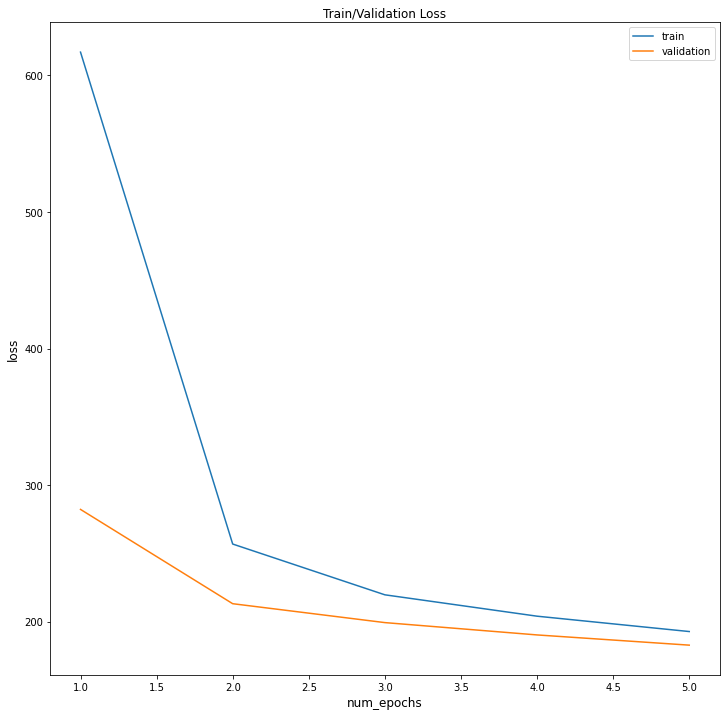

In [24]:
plot_graph(n_epochs)

In [25]:
torch.save(model,'bilstm_model')

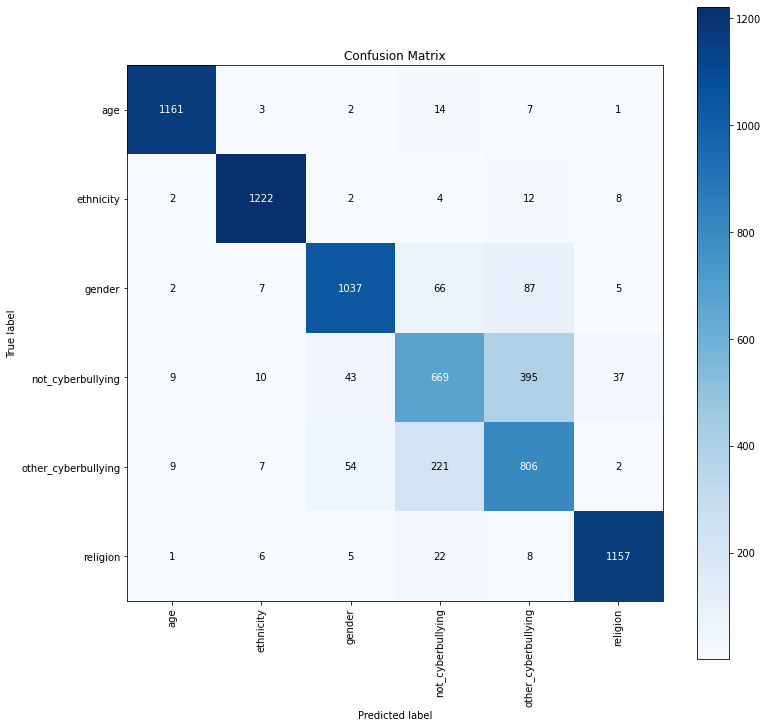

In [26]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in valid_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)